In [524]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MultiLabelBinarizer

In [525]:
# read and merge data
steam_data = pd.read_csv('../Data/steam_store_games_clean.csv', index_col=0)
steamspy_data = pd.read_csv('../Data/steam_spy_clean.csv', index_col=0)
    
merged = steam_data.merge(steamspy_data, how='inner', left_on='steam_appid', right_on='appid', suffixes=('', '_steamspy'))
print(merged.shape)
merged.head()

(59046, 30)


,type,name,steam_appid,required_age,is_free,dlc,developers,publishers,categories,release_date,...,positive,negative,owners,average_forever,median_forever,price,initialprice,languages,genre,tags
0,game,Dota 2,570,0,True,"[1241930, 652720]",['Valve'],['Valve'],"['Multi-player', 'Co-op', 'Steam Trading Cards...",2013-07-09,...,1607914,337779,200000000-500000000,40686,897,0.0,0.0,"['English', ' Bulgarian', ' Czech', ' Danish',...","['Action', ' Free to Play', ' Strategy']","['Free to Play', 'MOBA', 'Multiplayer']"
1,game,Apex Legends™,1172470,0,True,[],['Respawn Entertainment'],['Electronic Arts'],"['Multi-player', 'PvP', 'Online PvP', 'Co-op',...",2020-11-04,...,510084,104286,50000000-100000000,7380,743,0.0,0.0,"['English', ' French', ' Italian', ' German', ...","['Action', ' Adventure', ' Free to Play']","['Free to Play', 'Multiplayer', 'Battle Royale']"
2,game,PUBG: BATTLEGROUNDS,578080,0,True,[],"['KRAFTON, Inc.']","['KRAFTON, Inc.']","['Multi-player', 'PvP', 'Online PvP', 'Stats',...",2017-12-21,...,1228783,924298,50000000-100000000,22786,6637,0.0,0.0,"['English', ' Korean', ' Simplified Chinese', ...","['Action', ' Adventure', ' Free to Play', ' Ma...","['Survival', 'Shooter', 'Multiplayer']"
3,game,New World,1063730,0,False,[],['Amazon Games'],['Amazon Games'],"['Multi-player', 'MMO', 'PvP', 'Online PvP', '...",2021-09-28,...,176134,75910,50000000-100000000,7834,2978,3999.0,3999.0,"['English', ' French', ' Italian', ' German', ...","['Action', ' Adventure', ' Massively Multiplay...","['Massively Multiplayer', 'Open World', 'MMORPG']"
4,game,Team Fortress 2,440,0,True,[629330],['Valve'],['Valve'],"['Multi-player', 'Cross-Platform Multiplayer',...",2007-10-10,...,881554,58658,50000000-100000000,10279,399,0.0,0.0,"['English', ' Danish', ' Dutch', ' Finnish', '...","['Action', ' Free to Play']","['Free to Play', 'Hero Shooter', 'Multiplayer']"


In [526]:
# remove overlapping columns and reindex to reorder columns
df = merged[[
    'steam_appid',
    'type',
    'name',
    'release_date',
    'developers',
    'publishers',
    'dlc',
    'required_age',
    'is_free', 
    'categories',
    'tags',
    'genre',
    'languages',
    'positive',
    'negative',
    'owners',
    'average_forever',
    'median_forever',
    'price', 
    'initialprice',
    'controller_support', 
    'windows', 'mac', 'linux',
    'metacritic_score', 'metacritic_url',
    'initial', 'final', 'discount_percent',
]]

    
df = df.rename({
    'steam_appid': 'appid',
    'tags': 'steamspy_tags',
    'positive': 'positive_ratings',
    'negative': 'negative_ratings',
    'average_forever': 'average_playtime',
    'median_forever': 'median_playtime',
    'price': 'steamspy_price',
    'initialprice': 'steamspy_initialprice',
    'initial': 'store_initialprice',
    'final': 'store_finalprice'
}, axis=1)

df.head()

,appid,type,name,release_date,developers,publishers,dlc,required_age,is_free,categories,...,steamspy_initialprice,controller_support,windows,mac,linux,metacritic_score,metacritic_url,store_initialprice,store_finalprice,discount_percent
0,570,game,Dota 2,2013-07-09,['Valve'],['Valve'],"[1241930, 652720]",0,True,"['Multi-player', 'Co-op', 'Steam Trading Cards...",...,0.0,0,1,1,1,90.0,https://www.metacritic.com/game/pc/dota-2?ftag...,NaN,NaN,NaN
1,1172470,game,Apex Legends™,2020-11-04,['Respawn Entertainment'],['Electronic Arts'],[],0,True,"['Multi-player', 'PvP', 'Online PvP', 'Co-op',...",...,0.0,1,1,0,0,88.0,https://www.metacritic.com/game/pc/apex-legend...,NaN,NaN,NaN
2,578080,game,PUBG: BATTLEGROUNDS,2017-12-21,"['KRAFTON, Inc.']","['KRAFTON, Inc.']",[],0,True,"['Multi-player', 'PvP', 'Online PvP', 'Stats',...",...,0.0,0,1,0,0,NaN,NaN,NaN,NaN,NaN
3,1063730,game,New World,2021-09-28,['Amazon Games'],['Amazon Games'],[],0,False,"['Multi-player', 'MMO', 'PvP', 'Online PvP', '...",...,3999.0,0,1,0,0,70.0,https://www.metacritic.com/game/pc/new-world?f...,2505.692288,1252.846144,50.0
4,440,game,Team Fortress 2,2007-10-10,['Valve'],['Valve'],[629330],0,True,"['Multi-player', 'Cross-Platform Multiplayer',...",...,0.0,0,1,1,1,92.0,https://www.metacritic.com/game/pc/team-fortre...,NaN,NaN,NaN


In [527]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59046 entries, 0 to 59045
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   appid                  59046 non-null  int64  
 1   type                   59046 non-null  object 
 2   name                   59046 non-null  object 
 3   release_date           59046 non-null  object 
 4   developers             59046 non-null  object 
 5   publishers             59046 non-null  object 
 6   dlc                    59046 non-null  object 
 7   required_age           59046 non-null  int64  
 8   is_free                59046 non-null  bool   
 9   categories             59046 non-null  object 
 10  steamspy_tags          59046 non-null  object 
 11  genre                  59046 non-null  object 
 12  languages              59046 non-null  object 
 13  positive_ratings       59046 non-null  int64  
 14  negative_ratings       59046 non-null  int64  
 15  ow

In [528]:
df.describe()

,appid,required_age,positive_ratings,negative_ratings,average_playtime,median_playtime,steamspy_price,steamspy_initialprice,controller_support,windows,mac,linux,metacritic_score,store_initialprice,store_finalprice,discount_percent
count,5.904600e+04,59046.000000,5.904600e+04,59046.000000,59046.000000,59046.000000,59046.000000,59046.000000,59046.000000,59046.000000,59046.000000,59046.000000,3706.000000,52471.000000,52471.000000,52500.000000
mean,1.089432e+06,0.127866,1.354268e+03,219.834265,154.488975,131.890221,800.863073,838.705365,0.216933,0.999814,0.223605,0.150899,72.862115,715.289599,452.463718,33.446495
std,5.615203e+05,1.618049,1.851688e+04,4696.788191,1609.241963,1900.644912,1384.840264,1428.482446,0.412160,0.013648,0.416664,0.357954,10.441567,1334.146900,1174.868338,32.683803
min,1.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,49.542531,20.856672,0.000000
25%,6.282975e+05,0.000000,5.000000e+00,1.000000,0.000000,0.000000,199.000000,199.000000,0.000000,1.000000,0.000000,0.000000,67.000000,240.373782,109.168027,0.000000
50%,1.048845e+06,0.000000,1.900000e+01,6.000000,0.000000,0.000000,499.000000,499.000000,0.000000,1.000000,0.000000,0.000000,74.000000,480.621501,292.379179,30.000000
75%,1.514945e+06,0.000000,1.030000e+02,30.000000,0.000000,0.000000,999.000000,999.000000,0.000000,1.000000,0.000000,0.000000,80.000000,881.397764,576.591506,65.000000
max,2.338600e+06,180.000000,1.607914e+06,924298.000000,181605.000000,246408.000000,199990.000000,199990.000000,1.000000,1.000000,1.000000,1.000000,97.000000,146182.251411,146182.251411,100.000000


### Drop columns

In [529]:
# remove not useful columns
df = df.drop(['metacritic_url', # not useful for analysis
              ], axis=1)

### Format column types

In [530]:
# Change some integer types to other formats
df = df.astype({'appid': 'str', 
           'controller_support': 'bool', 
           'windows': 'bool',
           'mac': 'bool', 
           'linux': 'bool'})

# Datetime format
df['release_date'] = pd.to_datetime(df['release_date'])

# Format lists
list_cols = ['developers', 'publishers', 'dlc', 'categories', 'steamspy_tags', 'languages', 'genre']
for col in list_cols: 
    df[col] = df[col].apply(lambda x: eval(x))

In [531]:
df['owners'].value_counts()

0-20000                40759
20000-50000             7782
50000-100000            3856
100000-200000           2564
200000-500000           2142
500000-1000000           931
1000000-2000000          513
2000000-5000000          343
5000000-10000000          89
10000000-20000000         42
20000000-50000000         19
50000000-100000000         5
200000000-500000000        1
Name: owners, dtype: int64

In [532]:
to_combine = ['1000000-2000000', '2000000-5000000', '5000000-10000000', '10000000-20000000', '20000000-50000000', '50000000-100000000', '200000000-500000000']
df['owners'] = df['owners'].apply(lambda x: '>1000000' if x in to_combine else x)
df['owners'].value_counts()

0-20000           40759
20000-50000        7782
50000-100000       3856
100000-200000      2564
200000-500000      2142
>1000000           1012
500000-1000000      931
Name: owners, dtype: int64

### Train Test split
Conduct data processing and EDA with training data to prevent data leakage

In [533]:
# example: owners as target variable
X_train, X_test, y_train, y_test = train_test_split(df.drop(['owners'], axis=1), df['owners'], 
                                                    test_size=0.2, 
                                                    random_state=123, 
                                                    stratify=df['owners'])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(47236, 27)
(11810, 27)
(47236,)
(11810,)


### Handling missing values

In [534]:
# Columns with null values
impute_cols = X_train.columns[X_train.isnull().sum() > 0]
impute_cols

Index(['metacritic_score', 'store_initialprice', 'store_finalprice',
       'discount_percent'],
      dtype='object')

In [535]:
# Impute with median

imputer = ColumnTransformer([('median_imputer', SimpleImputer(strategy='median'), impute_cols)])

# Train
X_train_impute = pd.DataFrame(imputer.fit_transform(X_train), columns=impute_cols, index=X_train.index)
X_train = pd.concat([X_train.drop(impute_cols, axis=1), X_train_impute], axis=1)

# Test
X_test_impute = pd.DataFrame(imputer.transform(X_test), columns=impute_cols, index=X_test.index)
X_test = pd.concat([X_test.drop(impute_cols, axis=1), X_test_impute], axis=1)

print(X_train.shape)
print(X_test.shape)

(47236, 27)
(11810, 27)


### Exploratory Data Analysis

In [536]:
sns.set_style("darkgrid")

In [537]:
num_cols = list(df.select_dtypes(include=np.number).columns)
cat_cols = list(set(X_train.columns) - set(num_cols))

In [538]:
X_train.describe()

,required_age,positive_ratings,negative_ratings,average_playtime,median_playtime,steamspy_price,steamspy_initialprice,metacritic_score,store_initialprice,store_finalprice,discount_percent
count,47236.000000,4.723600e+04,47236.000000,47236.000000,47236.000000,47236.000000,47236.000000,47236.000000,47236.000000,47236.000000,47236.000000
mean,0.129605,1.349687e+03,209.448472,155.061161,131.275193,801.979444,839.901579,73.933631,691.518220,436.187559,33.111186
std,1.664991,1.755751e+04,2815.022551,1693.964694,1995.001376,1460.531820,1501.975283,2.597623,1352.907955,1203.480690,30.827513
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,58.455990,20.856672,0.000000
25%,0.000000,5.000000e+00,1.000000,0.000000,0.000000,199.000000,199.000000,74.000000,259.040325,133.806448,0.000000
50%,0.000000,1.900000e+01,6.000000,0.000000,0.000000,499.000000,499.000000,74.000000,480.811085,292.607732,30.000000
75%,0.000000,1.030000e+02,30.000000,0.000000,0.000000,999.000000,999.000000,74.000000,776.634095,523.899357,60.000000
max,180.000000,1.607914e+06,337779.000000,181605.000000,246408.000000,199990.000000,199990.000000,97.000000,146182.251411,146182.251411,100.000000


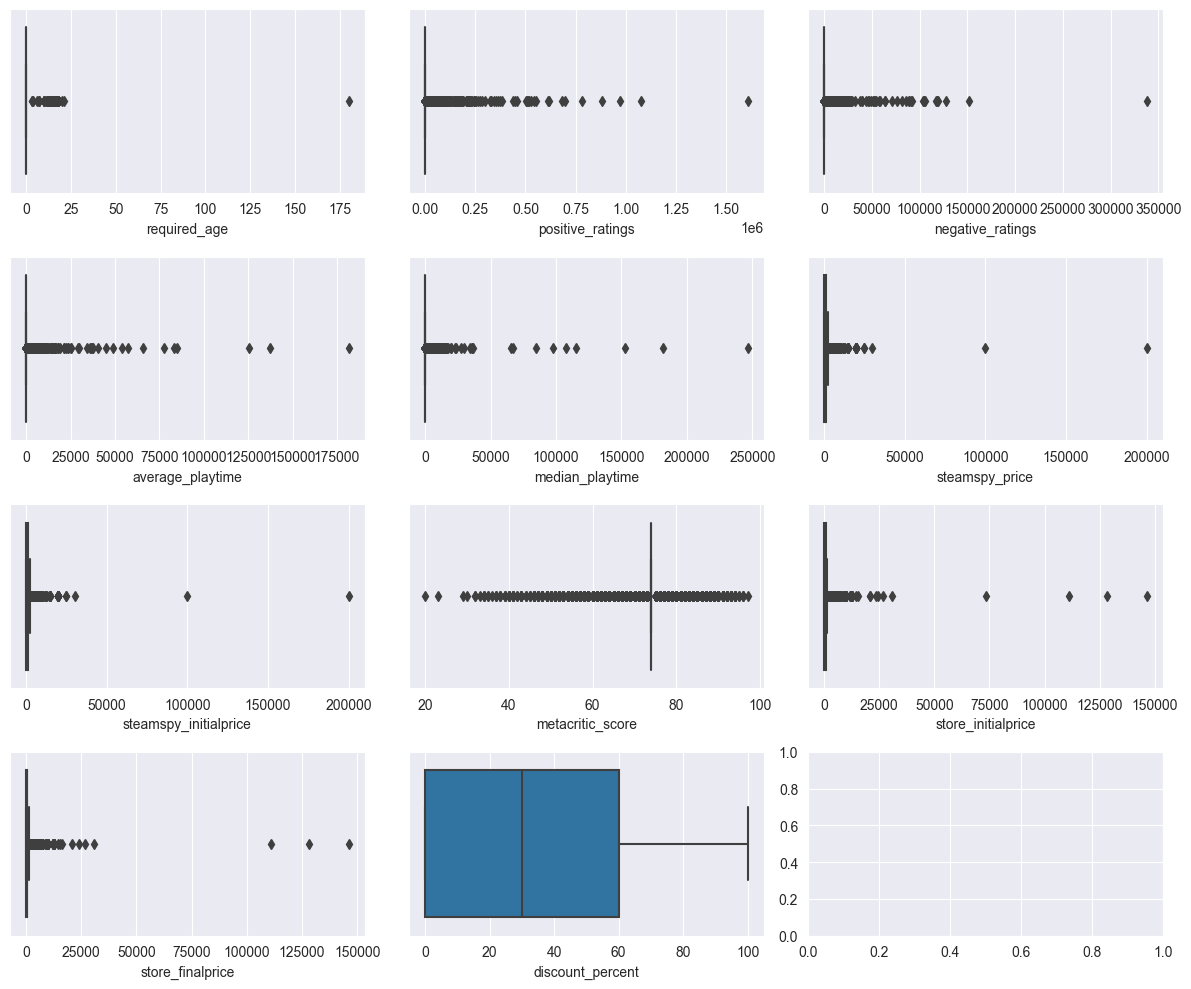

In [539]:
# Check distribution of numeric data - boxplot
fig, axes = plt.subplots(4, 3, figsize=(12,10))
for i, col in enumerate(num_cols):
    sns.boxplot(data=X_train, x=col, ax=fig.axes[i])
    
plt.tight_layout()

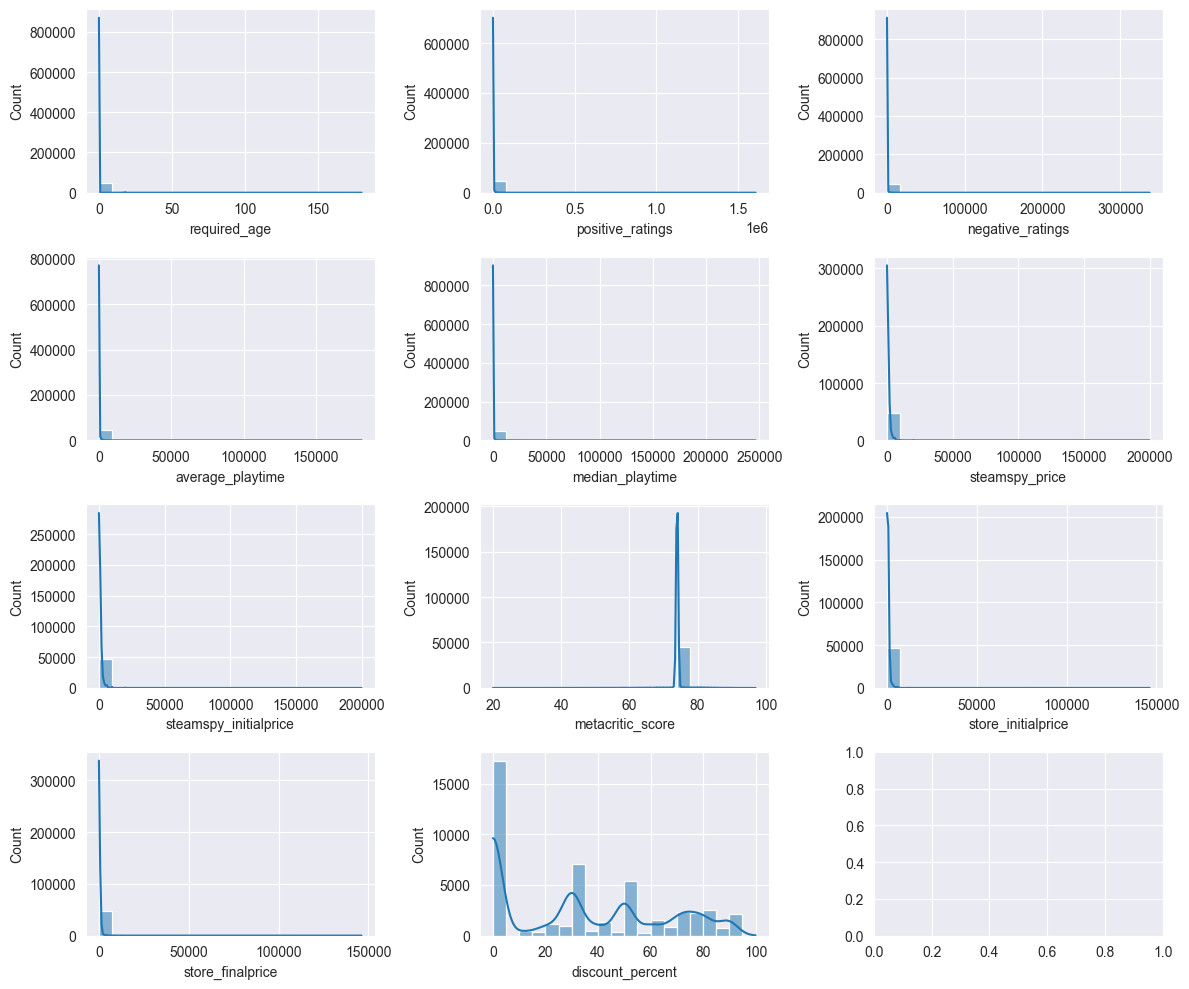

In [540]:
# Check distribution of numeric data - boxplot
fig, axes = plt.subplots(4, 3, figsize=(12,10))
for i, col in enumerate(num_cols):
    sns.histplot(X_train[col], kde=True, bins=20, ax=fig.axes[i])
    
plt.tight_layout()

C:\Users\SZJ\AppData\Local\Temp\ipykernel_23912\2573311113.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(round(X_train.corr(),2), cmap="Oranges", square=True, annot=True)


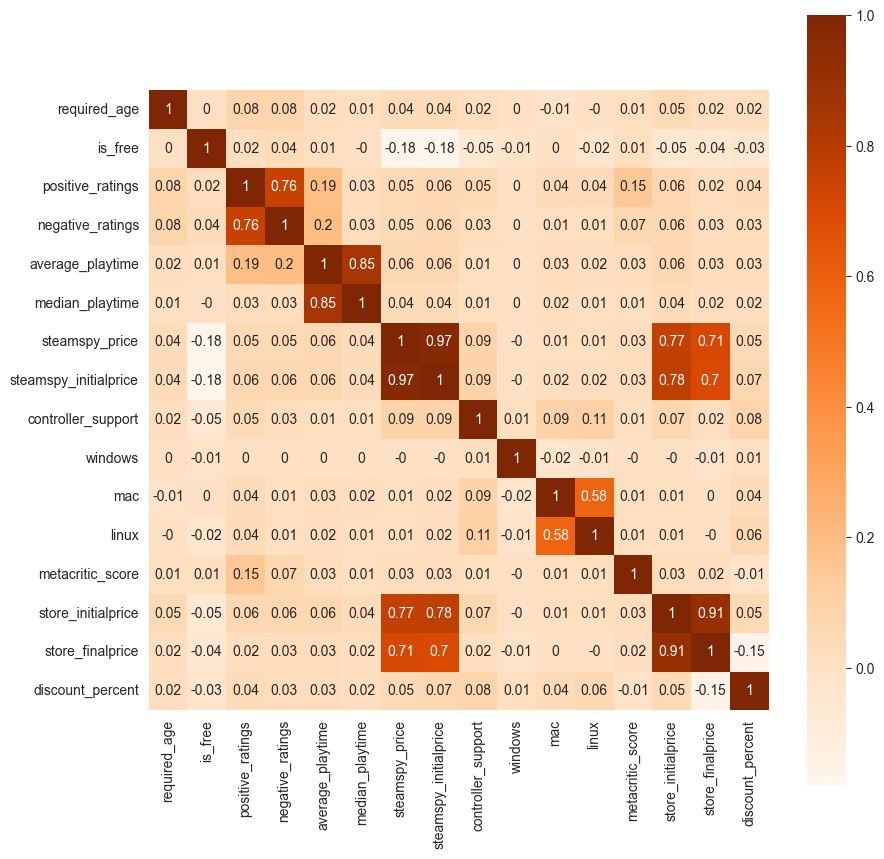

In [541]:
# Correlation analysis
plt.figure(figsize=(10,10))
sns.heatmap(round(X_train.corr(),2), cmap="Oranges", square=True, annot=True)
plt.show()

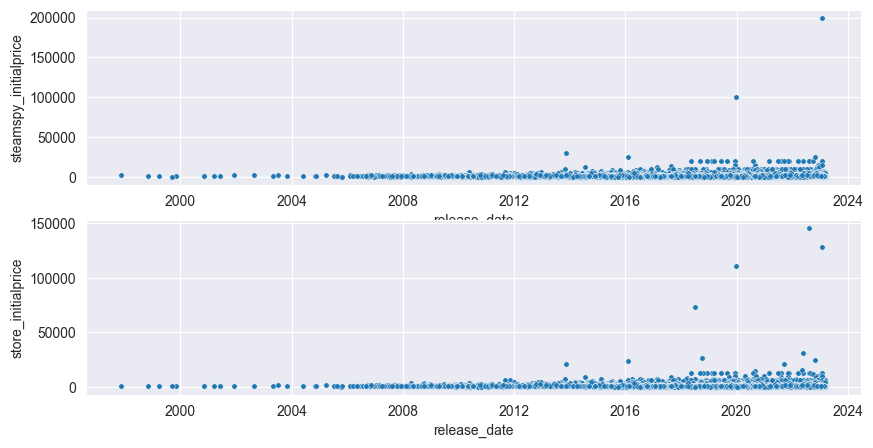

In [542]:
# Price changes over time
fig, axes = plt.subplots(2, 1, figsize=(10,5))
sns.scatterplot(data=X_train, x='release_date', y='steamspy_initialprice', s=15, ax=axes[0])
sns.scatterplot(data=X_train, x='release_date', y='store_initialprice', s=15, ax=axes[1])
plt.show()

In [543]:
# Function to find number of unique values
def find_unique(var_name):
    s = set()
    for ls in df[var_name]:
        for v in ls:
            s.add(v)
    return len(s)

list_cols = ['developers', 'publishers', 'dlc', 'categories', 'steamspy_tags', 'languages', 'genre']
print("Unique values:")
for col in list_cols:
    print(col, find_unique(col))

Unique values:
developers 37823
publishers 31094
dlc 37726
categories 40
steamspy_tags 433
languages 112
genre 54


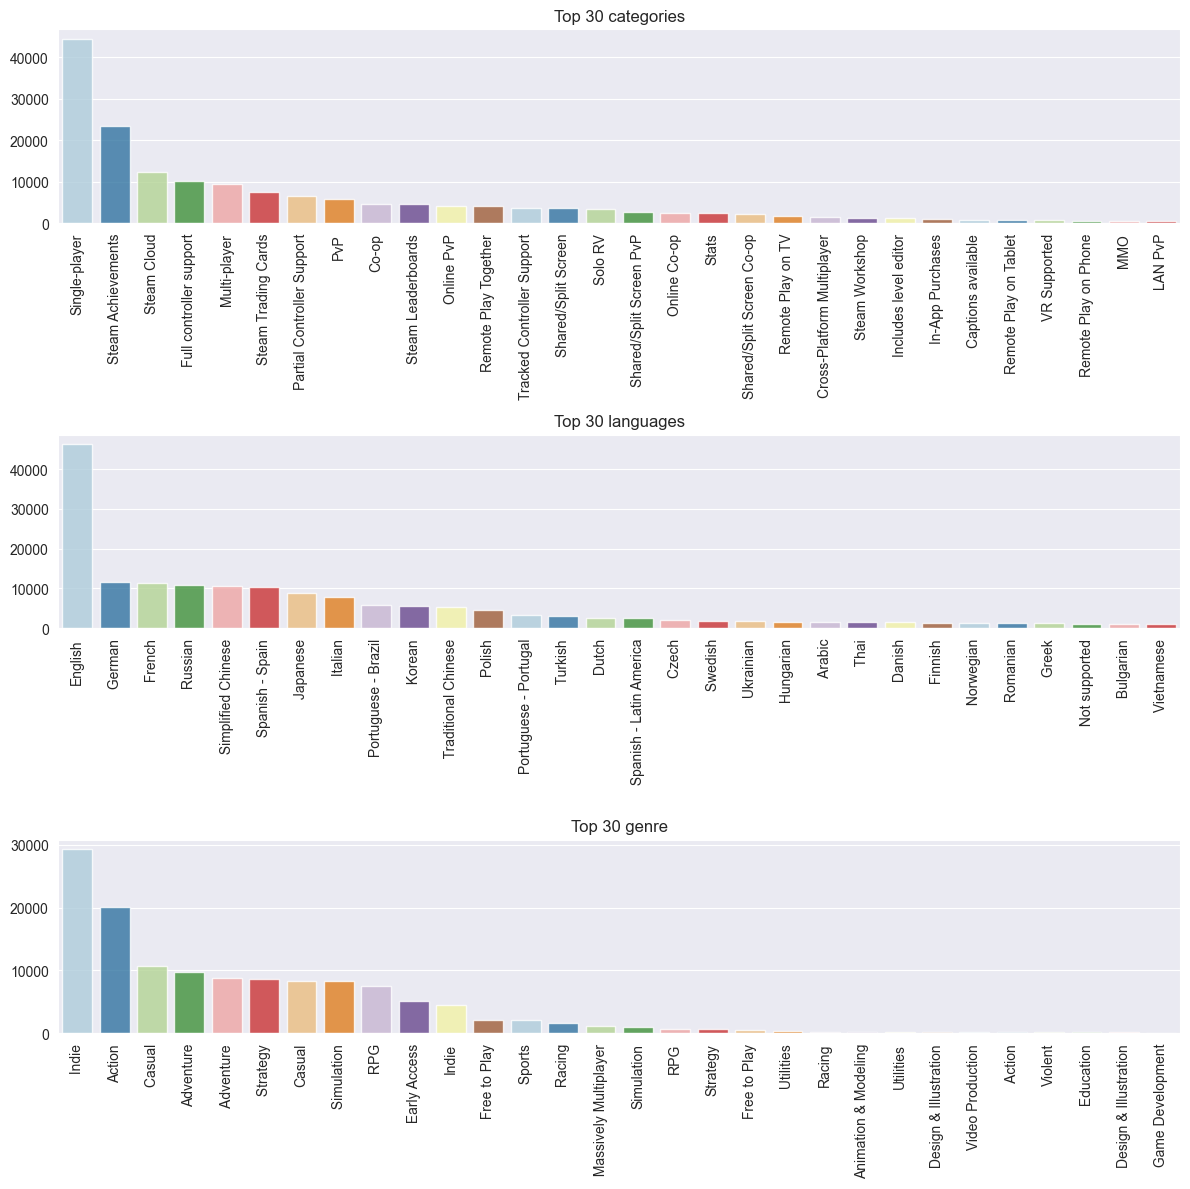

In [544]:
# Plot value counts for those with a reasonable amount of unique values
temp_cols = ['categories', 'languages', 'genre']

fig, axes = plt.subplots(3, 1, figsize=(12,12))
for i, col in enumerate(temp_cols):
    # Flattened version of the dataset for analysis
    X_train_temp = X_train.explode(col)
    
    # Show top 30 values
    temp = X_train_temp[col].value_counts()[:30]
    
    sns.barplot(x=temp.index, y=temp.values, alpha=0.8, palette='Paired', ax=fig.axes[i])
    fig.axes[i].tick_params(axis='x', rotation=90)
    fig.axes[i].set_title(f"Top 30 {col}")

plt.tight_layout()

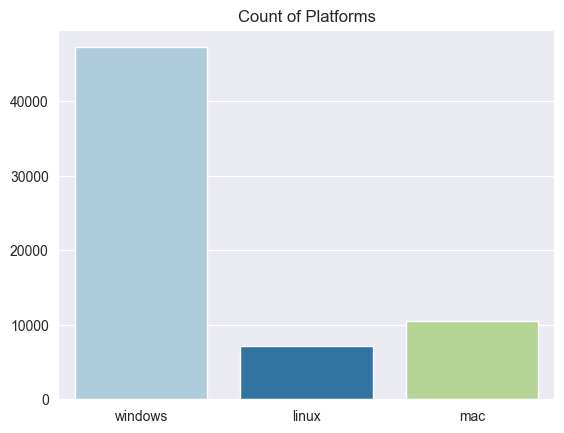

In [545]:
# Analyse platforms
platforms = ['windows', 'linux', 'mac']
platform_vals = [sum(X_train['windows']), sum(X_train['linux']), sum(X_train['mac'])]
sns.barplot(x=platforms, y=platform_vals, palette='Paired')
plt.title('Count of Platforms')
plt.show()

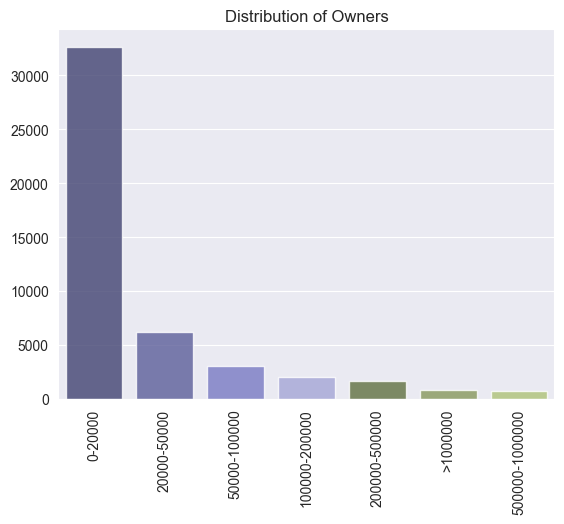

In [546]:
# Distribution of owners
temp = y_train.value_counts()
sns.barplot(x=temp.index, y=temp.values, alpha=0.8, palette='tab20b')
plt.xticks(rotation=90)
plt.title('Distribution of Owners')
plt.show()

<AxesSubplot: xlabel='language_count', ylabel='owners'>

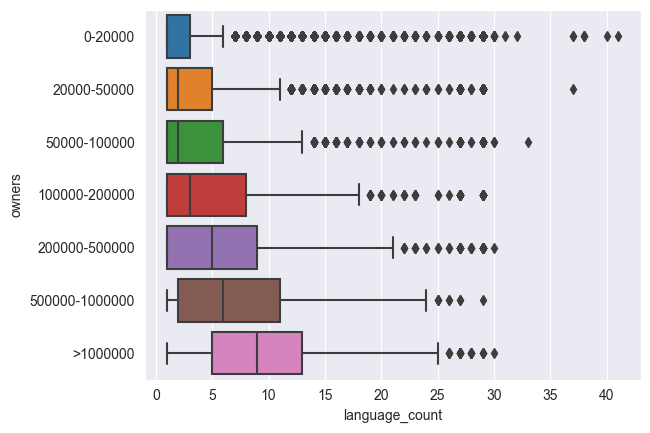

In [547]:
# Analyze number of languages supported by the various game download amounts
X_train['language_count'] = X_train['languages'].apply(lambda x: len(x))
order=['0-20000', '20000-50000', '50000-100000','100000-200000',
       '200000-500000', '500000-1000000', '>1000000']
sns.boxplot(x=X_train['language_count'], y=y_train, order=order)

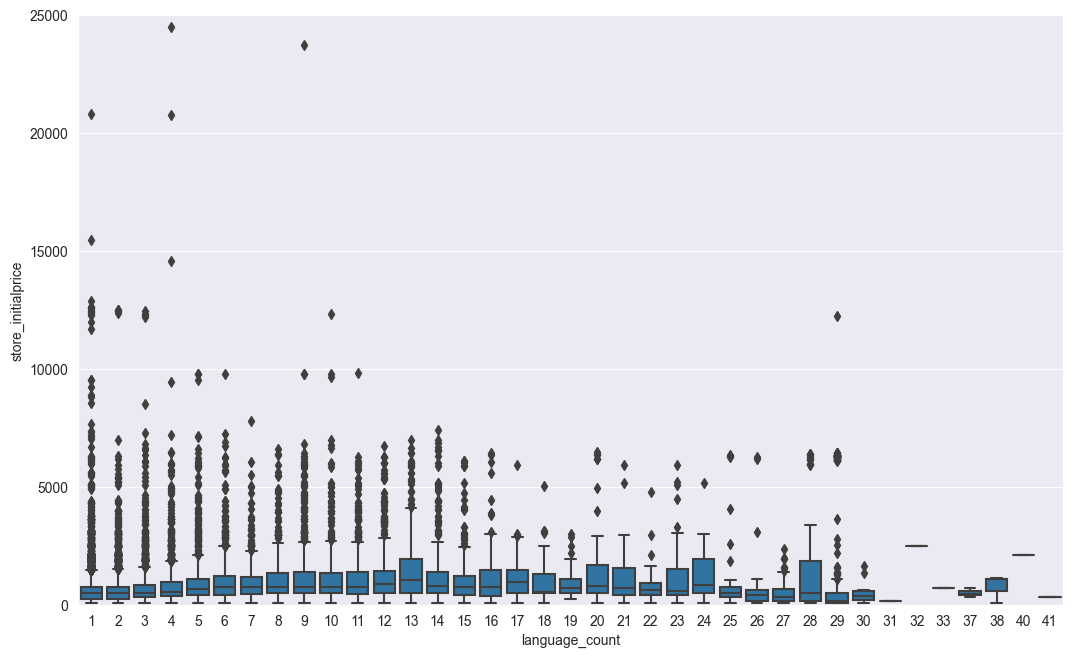

In [548]:
# Analyze game price based on languages supported
pricingforlang = sns.FacetGrid(X_train, ylim=(0, 25000))
pricingforlang.map_dataframe(sns.boxplot, x='language_count', y='store_initialprice')
pricingforlang.fig.set_figwidth(15)
pricingforlang.fig.set_figheight(8)

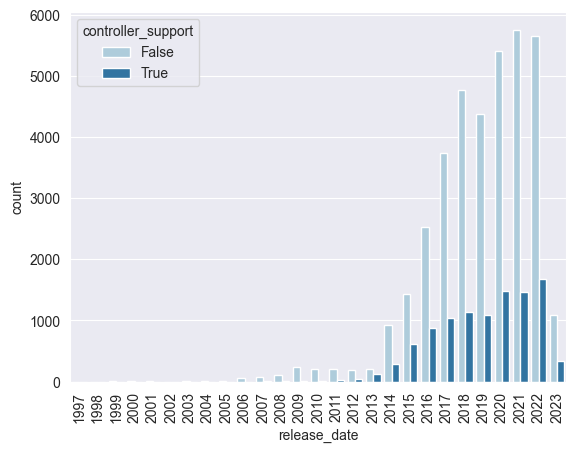

In [549]:
# Analyze controller support over time
sns.countplot(x=X_train['release_date'].dt.year, hue=X_train['controller_support'], palette="Paired")
plt.xticks(rotation=90)
plt.show()

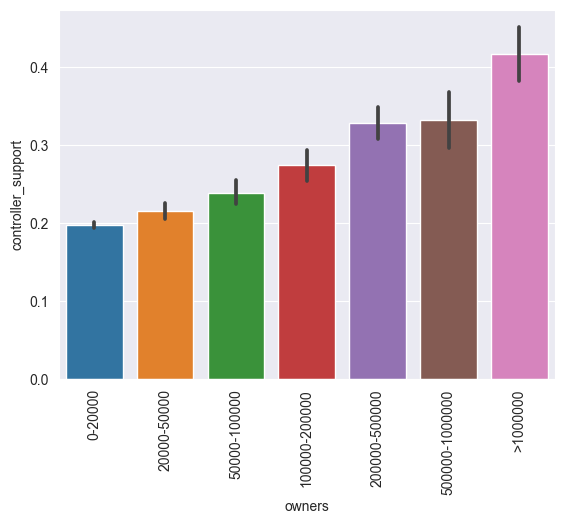

In [550]:
# Analyze controller support based by by the various game download amounts
sns.barplot(x=y_train, y=X_train['controller_support'], order=order)
plt.xticks(rotation=90)
plt.show()

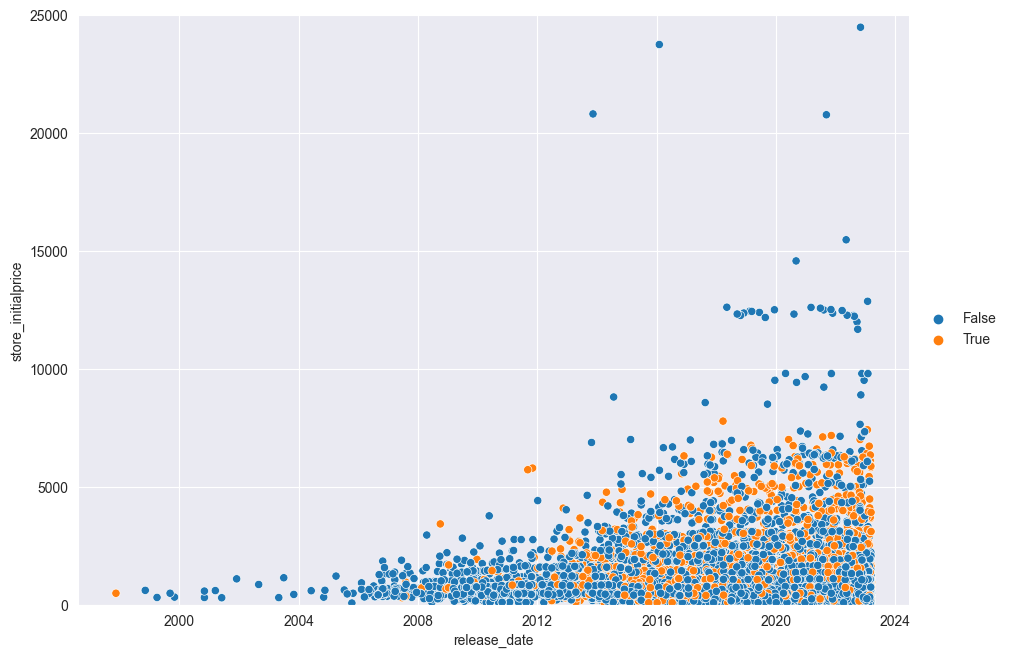

In [551]:
# Analyze if controller support affects pricing over time
pricingovertime = sns.FacetGrid(X_train, ylim=(0, 25000))
pricingovertime.map_dataframe(sns.scatterplot, x='release_date', y='store_initialprice', hue='controller_support')
pricingovertime.fig.set_figwidth(12)
pricingovertime.fig.set_figheight(8)
pricingovertime.add_legend()

### Feature Engineering

In [552]:
#dates
#AS of 2/4/2023
curr = date(2023,4,2)
df['days_since_released'] = df['release_date'].apply(lambda x : curr - x.to_pydatetime().date())
df['days_since_released']= df['days_since_released'].dt.days.astype('int16')
#30 days per month
df['months_since_released'] = df['days_since_released'] // 30
df['years_since_released'] = df['days_since_released'] // (12 *30)

In [553]:
#formula
#Total Reviews = Positive Reviews + Negative Reviews 
#Review Score = {Positive Reviews} / {Total Reviews} 
#Rating = Review Score - (Review Score - 0.5)*2^{-log_{10}(Total Reviews + 1)}

#calculate ratings
df['Total_Reviews'] = df['positive_ratings'] + df['negative_ratings']
df['inter'] = 2 ** (-1 * np.log10((df['Total_Reviews'] + 1)))
df['Review_Score'] = (df['positive_ratings'] / df['Total_Reviews'])
df['Ratings'] = df['Review_Score'] - (df['Review_Score'] - 0.5) * (2 ** (-1*np.log10(df['Total_Reviews'] + 1)))

In [554]:
#drop intermediate working columns
df = df.drop(columns=['inter','Total_Reviews','Review_Score'])

### Scale/Normalise

### Handle outliers

### Remove correlated variables

### One Hot Encoding

In [ ]:
#encode all bool objects 1 = True, 0 = False
df['is_free'] = df['is_free'].apply(lambda x : 0 if x == False else 1)
df['controller_support'] = df['controller_support'].apply(lambda x : 0 if x == False else 1)
df['windows'] = df['windows'].apply(lambda x : 0 if x == False else 1)
df['mac'] = df['mac'].apply(lambda x : 0 if x == False else 1)
df['linux'] = df['linux'].apply(lambda x : 0 if x == False else 1)

In [522]:
#encode type 1 = game, 0 = dlc
df['type'] = df['type'].apply(lambda x : 1 if x == "game" else 0)

In [523]:
#one hot for genre
mlb = MultiLabelBinarizer(sparse_output=True)

df = df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df.pop('genre')),
                index=df.index,
                columns=mlb.classes_))

KeyError: 'genre'

In [516]:
#encode DLC convert to integer 0 - no DLCs, else n DLCs can drop DLCs column
df['num_dlcs'] = df['dlc'].apply(lambda x : len(x))

KeyError: 'dlc'

In [517]:
#if want to drop dlc
df = df.drop(columns=['dlc'],axis=1)

KeyError: "['dlc'] not found in axis"

In [512]:
# Remove None Types
for i in range(0,len(df)):
    x = df.iloc[i]['categories']
    res = [c for c in x if c is not None]
    df.at[i,'categories'] = res

In [513]:
df.dtypes

appid                            object
type                              int64
name                             object
release_date             datetime64[ns]
developers                       object
publishers                       object
required_age                      int64
is_free                           int64
categories                       object
steamspy_tags                    object
genre                            object
languages                        object
positive_ratings                  int64
negative_ratings                  int64
owners                           object
average_playtime                  int64
median_playtime                   int64
steamspy_price                  float64
steamspy_initialprice           float64
controller_support                int64
windows                           int64
mac                               int64
linux                             int64
metacritic_score                float64
store_initialprice              float64


In [468]:
df

,appid,type,name,release_date,developers,publishers,required_age,is_free,categories,steamspy_tags,...,Racing,Sexual Content,Simulation,Software Training,Sports,Strategy,Utilities,Video Production,Violent,Web Publishing
0,570,1,Dota 2,2013-07-09,[Valve],[Valve],0,1,"[Multi-player, Co-op, Steam Trading Cards, Ste...","[Free to Play, MOBA, Multiplayer]",...,0,0,0,0,0,0,0,0,0,0
1,1172470,1,Apex Legends™,2020-11-04,[Respawn Entertainment],[Electronic Arts],0,1,"[Multi-player, PvP, Online PvP, Co-op, Online ...","[Free to Play, Multiplayer, Battle Royale]",...,0,0,0,0,0,0,0,0,0,0
2,578080,1,PUBG: BATTLEGROUNDS,2017-12-21,"[KRAFTON, Inc.]","[KRAFTON, Inc.]",0,1,"[Multi-player, PvP, Online PvP, Stats, Remote ...","[Survival, Shooter, Multiplayer]",...,0,0,0,0,0,0,0,0,0,0
3,1063730,1,New World,2021-09-28,[Amazon Games],[Amazon Games],0,0,"[Multi-player, MMO, PvP, Online PvP, Co-op, On...","[Massively Multiplayer, Open World, MMORPG]",...,0,0,0,0,0,0,0,0,0,0
4,440,1,Team Fortress 2,2007-10-10,[Valve],[Valve],0,1,"[Multi-player, Cross-Platform Multiplayer, Ste...","[Free to Play, Hero Shooter, Multiplayer]",...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59041,1702830,1,BLACKJACK and WAIFUS Hentai Version,2022-02-14,[KG/AM],[KG/AM],0,0,"[Single-player, Steam Achievements, Steam Trad...","[Simulation, Card Game, Visual Novel]",...,0,0,0,0,0,0,0,0,0,0
59042,1831560,1,Sprite Hunter,2021-12-17,[MCG],[MCG],0,0,[Single-player],"[Sexual Content, Nudity, RPG]",...,0,0,0,0,0,0,0,0,0,0
59043,457370,1,Alexa's Wild Night,2017-12-13,[Dharker Studio],[Dharker Studios Ltd],0,0,"[Single-player, Steam Achievements, Partial Co...","[Nudity, Sexual Content, Indie]",...,0,0,0,0,0,0,0,0,0,0
59044,904530,1,Erotic Jigsaw Challenge Vol 2,2018-08-07,[BarelyEntertainment],[BarelyEntertainment],0,0,"[Single-player, Steam Achievements]","[Nudity, Sexual Content, Indie]",...,0,0,0,0,0,0,0,0,0,0
